# 144

144 is a telephone number implemented throughout the Argentine Republic to report domestic violence. The datasets studied in this notebook contain the records of the calls to this service.
 

In [1]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sys

sys.version

'3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]'

In [2]:
# Identify DataSource 
# We have 3 datasets with data of 2020, 2021, 2022

# !ls -la ./data

years = [2020, 2021, 2022]
data_dict = {}
for year in years:
    data_dict[year] = pd.read_csv(f'./data/linea144-{year}.csv', parse_dates=['fecha'])

data = pd.concat(data_dict, ignore_index=True)
data.sample(10) 

,fecha,prov_residencia_persona_en_situacion_violencia,genero_persona_en_situacion_de_violencia,edad_persona_en_situacion_de_violencia,pais_nacimiento_persona_en_situacion_de_violencia,tipo_de_violencia_fisica,tipo_de_violencia_psicologica,tipo_de_violencia_sexual,tipo_de_violencia_economica_y_patrimonial,tipo_de_violencia_simbolica,tipo_de_violencia_domestica,modalidad_de_violencia_institucional,modalidad_de_violencia_laboral,modalidad_violencia_contra_libertad_reproductiva,modalidad_de_violencia_obstetrica,modalidad_de_violencia_mediatica,modalidad_de_violencia_otras,vinculo_con_la_persona_agresora,genero_de_la_persona_agresora,Unnamed: 19
62236,2022-04-12,Santa Fe,Mujer,NaN,NaN,Si,Si,No,Si,No,Si,No,No,No,No,No,No,Ex pareja,Varon,NaN
41531,2021-06-19,Mendoza,Mujer,47.0,Argentina,No,Si,No,Si,No,Si,No,No,No,No,No,No,Ex pareja,Varon,NaN
27133,2020-11-26,Buenos Aires,Mujer,30.0,Argentina,No,Si,No,Si,Si,Si,No,No,No,No,No,No,Pareja,Varon,NaN
39573,2021-05-20,Buenos Aires,Mujer,NaN,NaN,No,Si,No,No,No,Si,No,No,No,No,No,No,Ex pareja,Varon,NaN
20293,2020-08-27,Buenos Aires,Mujer,55.0,Argentina,Si,Si,No,Si,Si,Si,No,No,No,No,No,No,Otro familiar,Varon,NaN
40285,2021-05-31,Ciudad Autónoma de Buenos Aires,Mujer,30.0,Venezolana,No,Si,No,No,No,Si,No,No,No,No,No,No,Pareja,Varon,NaN
60194,2022-03-15,Buenos Aires,Mujer,26.0,Argentina,Si,Si,Si,Si,Si,Si,No,No,No,No,No,No,Pareja,Varon,NaN
13748,2020-06-11,Córdoba,Mujer,74.0,NaN,Si,Si,No,No,No,Si,No,No,No,No,No,No,Pareja,Varon,NaN
47212,2021-09-11,San Juan,Mujer,25.0,Argentina,No,Si,No,Si,No,Si,No,No,No,No,No,No,Ex pareja,Varon,NaN
27243,2020-11-28,Ciudad Autónoma de Buenos Aires,Mujer,32.0,Argentina,Si,Si,No,No,No,Si,No,No,No,No,No,No,Pareja,Varon,NaN


In [3]:
# Validate that the date has been read correctly

data.info()
assert data.fecha.dtype == 'datetime64[ns]', "'fecha' must be a datetime64 type"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79565 entries, 0 to 79564
Data columns (total 20 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   fecha                                              79565 non-null  datetime64[ns]
 1   prov_residencia_persona_en_situacion_violencia     78401 non-null  object        
 2   genero_persona_en_situacion_de_violencia           77924 non-null  object        
 3   edad_persona_en_situacion_de_violencia             64107 non-null  float64       
 4   pais_nacimiento_persona_en_situacion_de_violencia  52696 non-null  object        
 5   tipo_de_violencia_fisica                           79565 non-null  object        
 6   tipo_de_violencia_psicologica                      79565 non-null  object        
 7   tipo_de_violencia_sexual                           79565 non-null  object        
 8   tipo_de_violenci

### Filling in missing categorical variables by using the mode
* [Heres how to fill in missing values in a dataset](https://thecleverprogrammer.com/2023/03/14/heres-how-to-fill-in-missing-values-in-a-dataset/) 

#### Summary from the article

> So the first step is to see if your data has missing values. If your data has missing values, you need to check the distribution of each numerical variable (with missing values). If the values in the numerical variables are missing, use the Mean value if the variable is in a normal distribution. Otherwise, choose Median. And if the variable is categorical or discrete, you can select mode. So you need to choose a different measure for each variable. I hope you liked this article on how to fill in missing values in your data. Feel free to ask valuable questions in the comments section below.

In [4]:
# Filling nan rows with mode
def fill_with_mode_the_nan_values(field):

    # n records NaN to theis field 
    fields_nan = data[field].isna().sum()
    print(f'Processing records NaN to {field}: {fields_nan}')
    
    if fields_nan > 0:
        # filling using the mode, like shown in link above
        field_mode = data[field].mode()[0]

        data[field].fillna(field_mode, inplace=True)

fields = ['prov_residencia_persona_en_situacion_violencia', 'genero_persona_en_situacion_de_violencia', 'pais_nacimiento_persona_en_situacion_de_violencia', 'vinculo_con_la_persona_agresora', 'genero_de_la_persona_agresora']

[fill_with_mode_the_nan_values(field) for field in fields]

Processing records NaN to prov_residencia_persona_en_situacion_violencia: 1164
Processing records NaN to genero_persona_en_situacion_de_violencia: 1641
Processing records NaN to pais_nacimiento_persona_en_situacion_de_violencia: 26869
Processing records NaN to vinculo_con_la_persona_agresora: 2992
Processing records NaN to genero_de_la_persona_agresora: 8235


[None, None, None, None, None]

### Filling numeric values (edad_persona_en_situacion_de_violencia) using the median
* Mean, when we have a normal distribution
* **Median**, otherwise

Kurtosis: 1.328292544349127
There are/was 15458 missing values to field "edad_persona_en_situacion_de_violencia"


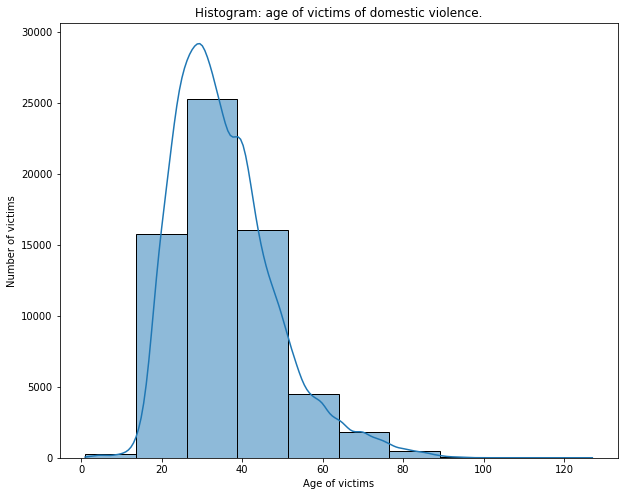

In [5]:
# Histogram: distribution ins't normal

# Calculate kurtosis
print(f'Kurtosis: {data.edad_persona_en_situacion_de_violencia.kurtosis()}')

# Count of missing values
print(f'There are/was {data.edad_persona_en_situacion_de_violencia.isna().sum()} missing values to field "edad_persona_en_situacion_de_violencia"')

plt.figure(figsize=(10, 8))
f = sns.histplot(data['edad_persona_en_situacion_de_violencia'], bins=10, kde=True)
f.set_title('Histogram: age of victims of domestic violence.')
f.set_xlabel("Age of victims")
f.set_ylabel("Number of victims")
plt.show()

# Calculate the median
age_median = data.edad_persona_en_situacion_de_violencia.median()

# Filling data with the mean
data.fillna(age_median, inplace=True)


In [6]:
# Types and modalities whose values are boolean

# 1. Define wich fields will be processed 
boolean_fields = ['tipo_de_violencia_fisica', 'tipo_de_violencia_psicologica', 'tipo_de_violencia_sexual', \
                    'tipo_de_violencia_economica_y_patrimonial', 'tipo_de_violencia_simbolica', 'tipo_de_violencia_domestica',
                    'modalidad_de_violencia_institucional', 'modalidad_de_violencia_laboral', \
                    'modalidad_violencia_contra_libertad_reproductiva', 'modalidad_de_violencia_obstetrica', \
                    'modalidad_de_violencia_mediatica', 'modalidad_de_violencia_otras']

# 2. View and confirmation that they are boolean
def fields_view_validation(field):
    print(f"Types for field '{field}': {data[field].unique()}")

# 3. Show
[fields_view_validation(field) for field in boolean_fields]

# 3. Cast to boolean 
mapping = {'Si': True, 'SI': True, 'No': False, 'NO': False}

for field in boolean_fields:
    data[field] = data[field].map(mapping)


Types for field 'tipo_de_violencia_fisica': ['Si' 'No']
Types for field 'tipo_de_violencia_psicologica': ['Si' 'No']
Types for field 'tipo_de_violencia_sexual': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_economica_y_patrimonial': ['No' 'Si']
Types for field 'tipo_de_violencia_simbolica': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_domestica': ['Si' 'No']
Types for field 'modalidad_de_violencia_institucional': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_laboral': ['No' 'Si' 'SI']
Types for field 'modalidad_violencia_contra_libertad_reproductiva': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_obstetrica': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_mediatica': ['No' 'Si']
Types for field 'modalidad_de_violencia_otras': ['No' 'Si']


### Show the information

In [7]:
# Boolean fields: Mapping fields to a readable title

boolean_fields_titles = ['Type of Physical Violence',
'Type of Psychological Violence',
'Type of Sexual Violence',
'Type of Economic And Patrimonial Violence',
'Type of Symbolic Violence',
'Type of Domestic Violence',
'Modality of Institutional Violence',
'Type of Workplace Violence',
'Modality Violence Against Reproductive Freedom',
'Modality of Obstetric Violence',
'Modality of Media Violence',
'Modality of Violence Other']

boolean_fields_dict = {}
for (id, title) in zip(boolean_fields, boolean_fields_titles):
    boolean_fields_dict[id] = title

# Validating
data[boolean_fields].sample(10)

,tipo_de_violencia_fisica,tipo_de_violencia_psicologica,tipo_de_violencia_sexual,tipo_de_violencia_economica_y_patrimonial,tipo_de_violencia_simbolica,tipo_de_violencia_domestica,modalidad_de_violencia_institucional,modalidad_de_violencia_laboral,modalidad_violencia_contra_libertad_reproductiva,modalidad_de_violencia_obstetrica,modalidad_de_violencia_mediatica,modalidad_de_violencia_otras
10364,False,True,True,False,True,True,False,False,False,False,False,False
17146,False,True,False,True,True,True,False,False,False,False,False,False
13476,True,True,False,False,False,True,False,False,False,False,False,False
58345,True,True,False,False,False,True,False,False,False,False,False,False
64289,False,True,True,True,True,True,False,False,False,False,False,False
15690,True,True,False,False,False,True,False,False,False,False,False,False
75715,True,True,False,True,True,True,False,False,False,False,False,False
54564,True,True,False,False,False,True,False,False,False,False,False,False
56377,True,True,False,False,False,True,False,False,False,False,False,False
34726,True,True,True,True,True,True,False,False,False,False,False,False


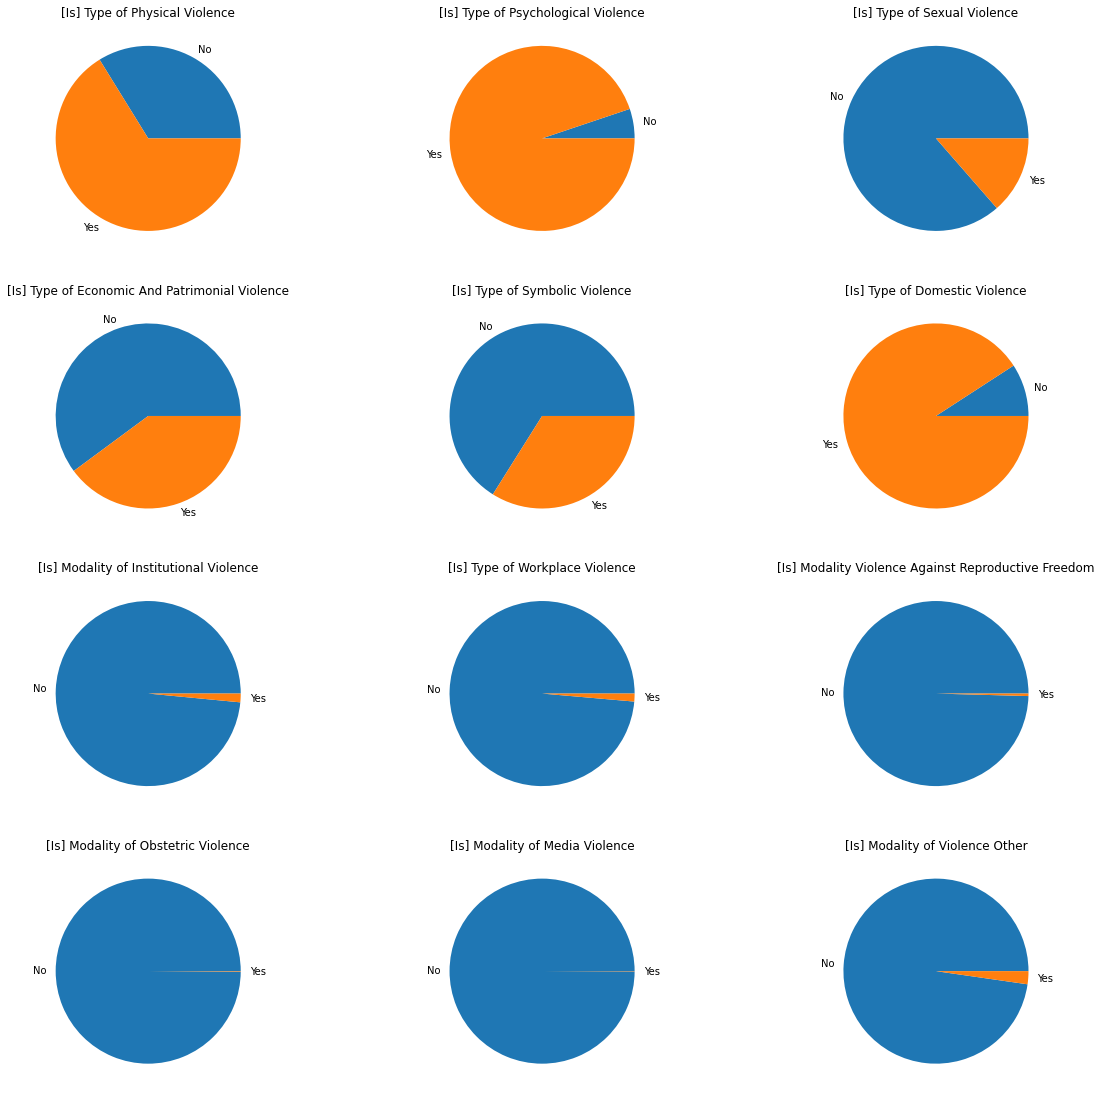

In [8]:
# Showing boolean features

cols = 3
total = len(boolean_fields_dict)
rows = total // cols
rows += 1 if total % cols != 0 else rows
position = range(1, total + 1)

fig = plt.figure(1, figsize=(20,40))    
for k, id in enumerate(boolean_fields_dict):
    ax = fig.add_subplot(rows, cols, position[k])
    ax = data.groupby(id).size().plot(kind='pie', title= f'[Is] {boolean_fields_dict[id]}', labels=['No', 'Yes'])
    
plt.show()

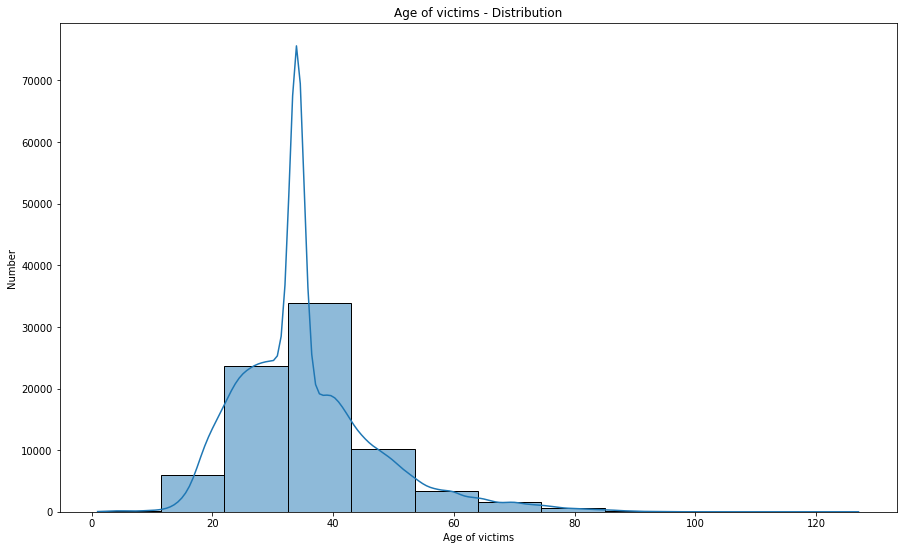

In [9]:
# Distribution of victims by age
plt.figure(figsize=(15,9))
fig = sns.histplot(data['edad_persona_en_situacion_de_violencia'], bins=12, kde=True)
fig.set_title(('Age of victims - Distribution'))
fig.set_xlabel('Age of victims')
fig.set_ylabel('Number')
plt.show()

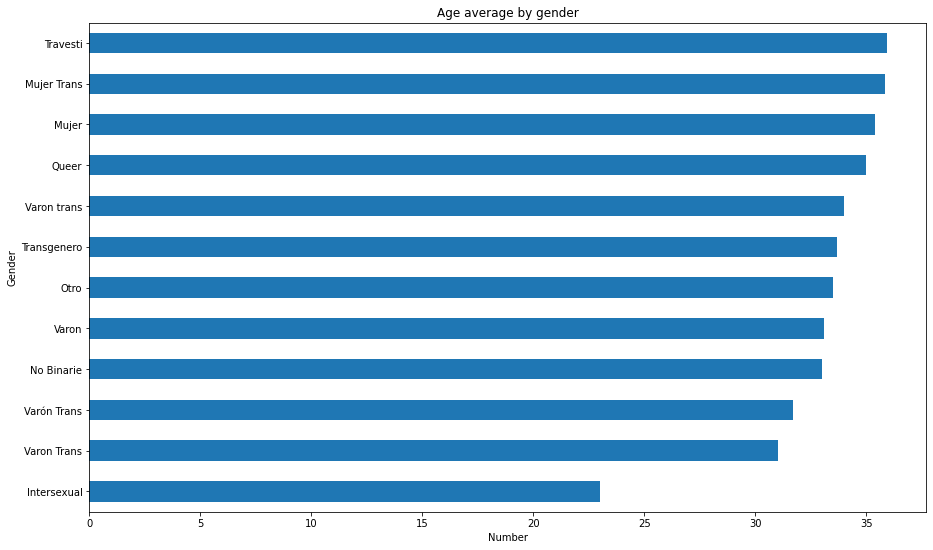

In [10]:
# Age average by gender
plt.figure(figsize=(15,9))
ax = data.groupby('genero_persona_en_situacion_de_violencia')['edad_persona_en_situacion_de_violencia'].mean() \
    .sort_values() \
    .plot(kind='barh', title='Age average by gender')
ax.set_xlabel('Number')
ax.set_ylabel('Gender')
plt.show()


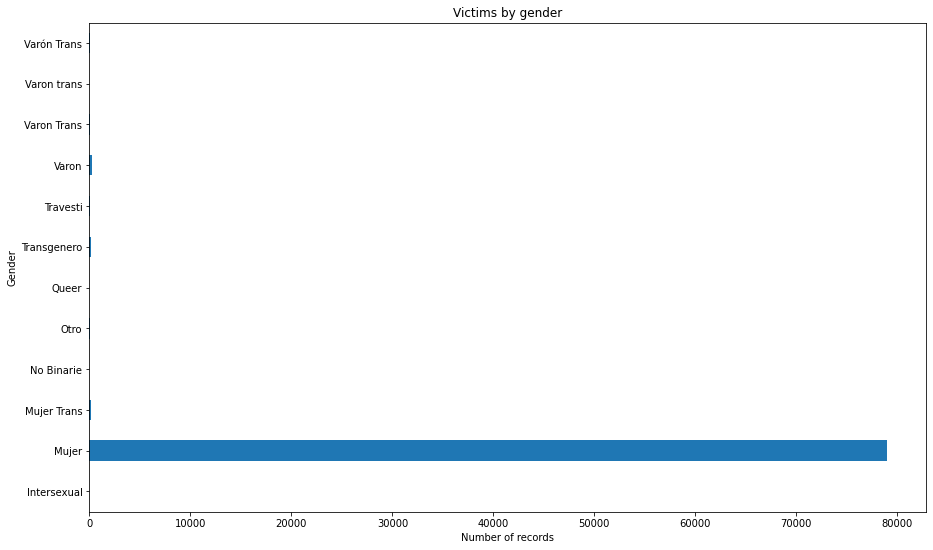

In [11]:
# Victims by gender
plt.figure(figsize=(15,9))
ax = data.groupby('genero_persona_en_situacion_de_violencia').size() \
    .plot(kind='barh', title='Victims by gender')

ax.set_ylabel('Gender')
ax.set_xlabel('Number of records')

plt.show()

In [18]:
# Add column with month of call
def month(value):
    return value.month

def year(value):
    return value.year

data['month'] = data.fecha.map(month)
data['year'] = data.fecha.map(year)

data[['fecha', 'month', 'year']].sample(5)

,fecha,month,year
7977,2020-04-10,4,2020
10979,2020-05-10,5,2020
21249,2020-09-10,9,2020
43911,2021-07-25,7,2021
72359,2022-09-15,9,2022


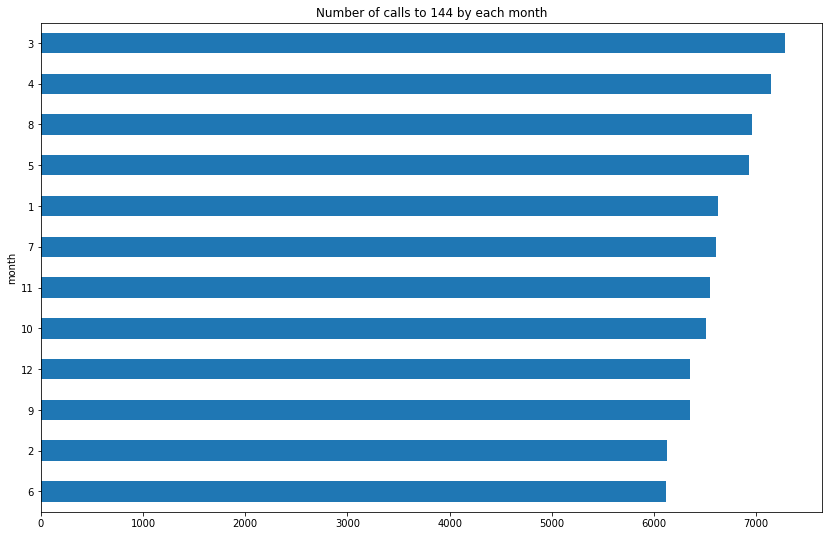

In [13]:
# Calls by month
plt.figure(figsize=(14,9))
ax1 = data.groupby('month').size().sort_values() \
    .plot(kind='barh', title='Number of calls to 144 by each month')
plt.show()



In [15]:
# Mean and median of victims age
mean_age = data.edad_persona_en_situacion_de_violencia.mean()
median_age = data.edad_persona_en_situacion_de_violencia.median()

print(f'The mean age of victims is {round(mean_age, 0)} yo')
print(f'The median age of vinctims is {round(mean_age, 0)} yo')

The mean age of victims is 35.0 yo
The median age of vinctims is 35.0 yo


<AxesSubplot:xlabel='month,year'>

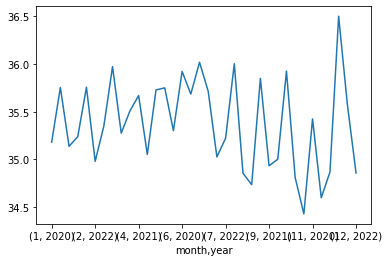

In [26]:
# age evolution
data.groupby(['month', 'year'])['edad_persona_en_situacion_de_violencia'].agg('mean').plot(kind='line')

# data.info()